# Using OBIA for estimating area of Solar Panels in Spain

Using STAC, I am going to download imagery, segment the solar panels and estimate the area they occupy in the fields.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

import rasterio as rio
import xarray as xr
import rioxarray

import dask.array as da # handle dask arrays
from IPython.display import Image # visualize URLs
import pystac_client # connecting to the STAC API
from rasterio.enums import Resampling # perform re-sampling operations
import shapely # create vector objects
import stackstac # build an on-demand STAC data cube


In [2]:
api_url = 'https://earth-search.aws.element84.com/v1'
client = pystac_client.Client.open(api_url)
for collection in client.get_collections():
    print(collection)

<CollectionClient id=sentinel-2-pre-c1-l2a>
<CollectionClient id=cop-dem-glo-30>
<CollectionClient id=naip>
<CollectionClient id=cop-dem-glo-90>
<CollectionClient id=landsat-c2-l2>
<CollectionClient id=sentinel-2-l2a>
<CollectionClient id=sentinel-2-l1c>
<CollectionClient id=sentinel-2-c1-l2a>
<CollectionClient id=sentinel-1-grd>


In [3]:
collection = 'sentinel-2-l2a'

#coordinates 
lat = 37.364
lon = -6.923
point = shapely.Point(lon, lat)
date_range = '2025-04-01/2025-05-16'

In [4]:
search = client.search(
    collections = [collection],
    intersects=point,
    datetime=date_range,
    query = ['eo:cloud_cover<10']
)

items = search.item_collection()
len(items)

2

In [5]:
item_df = gpd.GeoDataFrame.from_features(items.to_dict(), crs = 'EPSG:4326')
item_df 

,geometry,created,platform,constellation,instruments,eo:cloud_cover,proj:centroid,mgrs:utm_zone,mgrs:latitude_band,mgrs:grid_square,...,s2:datastrip_id,s2:reflectance_conversion_factor,datetime,s2:sequence,earthsearch:s3_path,earthsearch:payload_id,earthsearch:boa_offset_applied,processing:software,updated,proj:code
0,"POLYGON ((-7.69213 37.94031, -7.87145 37.3139,...",2025-05-15T15:21:11.337Z,sentinel-2b,sentinel-2,[msi],6.094903,"{'lat': 37.42613, 'lon': -7.22372}",29,S,PB,...,S2B_OPER_MSI_L2A_DS_2BPS_20250515T135717_S2025...,0.980395,2025-05-15T11:20:58.831000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/29/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/f069...,True,{'sentinel2-to-stac': '2025.03.06'},2025-05-15T15:21:11.337Z,EPSG:32629
1,"POLYGON ((-7.69554 37.94035, -7.87124 37.32824...",2025-04-22T19:32:50.586Z,sentinel-2a,sentinel-2,[msi],4.524603,"{'lat': 37.42651, 'lon': -7.2248}",29,S,PB,...,S2A_OPER_MSI_L2A_DS_2APS_20250422T180305_S2025...,0.992053,2025-04-22T11:21:12.566000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/29/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/0950...,True,{'sentinel2-to-stac': '2025.03.06'},2025-04-22T19:32:50.586Z,EPSG:32629


In [6]:
item_df['s2:nodata_pixel_percentage']

0    4.252186
1    4.083012
Name: s2:nodata_pixel_percentage, dtype: float64

In [7]:
item_df.explore()

In [8]:
ids = item_df.loc[
  (item_df['eo:cloud_cover'] <= 5) &
  (item_df['s2:nodata_pixel_percentage'] <= 4.1)
]

item = items[ids.index[0]]
item.datetime

datetime.datetime(2025, 4, 22, 11, 21, 12, 566000, tzinfo=tzutc())

In [9]:
aoi = gpd.read_file('solar_aoi.json')
bbox = aoi.total_bounds
aoi.explore()

In [10]:
thumbnail = item.assets["thumbnail"].href
Image(url = thumbnail)

In [56]:
assets = ["red","green","blue","nir","scl"]
cube_all = stackstac.stack(
    item, 
    assets, 
    bounds_latlon = bbox, 
    epsg=32629
    )
scl = cube_all.sel(band=["scl"])
s2_mask = da.isin(scl, [3,8,9])
cube = cube_all.where(~s2_mask)
cube = cube.to_dataset(dim = 'band')

In [57]:
cube.red

<xarray.DataArray 'red' (time: 1, y: 263, x: 267)> Size: 562kB
dask.array<getitem, shape=(1, 263, 267), dtype=float64, chunksize=(1, 263, 267), chunktype=numpy.ndarray>
Coordinates: (12/47)
  * time                                     (time) datetime64[ns] 8B 2025-04...
    id                                       (time) <U24 96B 'S2A_29SPB_20250...
  * x                                        (x) float64 2kB 6.829e+05 ... 6....
  * y                                        (y) float64 2kB 4.138e+06 ... 4....
    view:sun_azimuth                         float64 8B 145.1
    s2:degraded_msi_data_percentage          float64 8B 0.0116
    ...                                       ...
    s2:product_uri                           <U65 260B 'S2A_MSIL2A_20250422T1...
    s2:cloud_shadow_percentage               float64 8B 2.312
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    s2:vegetation_percentage                 float64 8B 55.12
    earthsearch:payload_id                   <U74 296B 'roda-sentinel2/workfl...
    epsg                                     int64 8B 32629

In [54]:
# Find max value per band
band_max = cube.max(dim=["time", "x", "y"])

# Normalize cube by band max
cube_normalized = cube / band_max


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0952..0.4324].


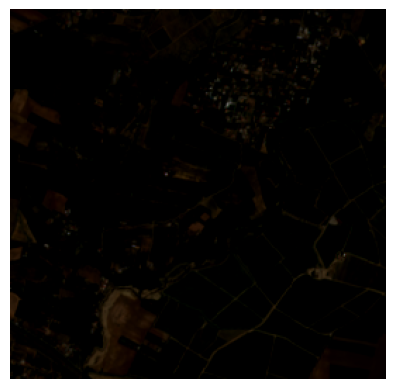

In [60]:
rgb = np.dstack((
    cube['red'][0,:,:],
    cube['green'][0,:,:],
    cube['blue'][0,:,:])
)
plt.imshow(rgb)
plt.axis('off')
plt.show()

In [61]:
#calculate NDVI
ndvi = (cube['nir'] - cube['red']) / (cube['nir'] + cube['red'] )

In [68]:
float(ndvi.max().compute()), float(ndvi.min().compute())

(107.99999999999942, -441.0000000000078)

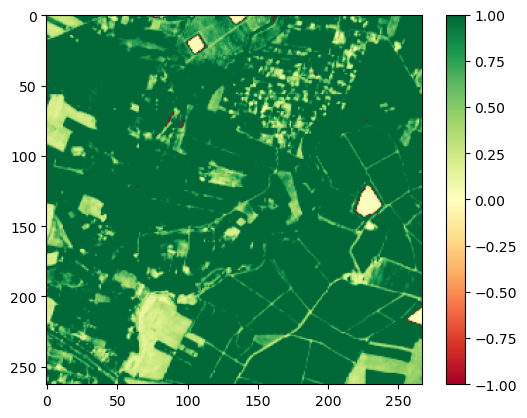

In [72]:
plt.imshow(ndvi[0,:,:], cmap='RdYlGn', vmin = -1, vmax = 1)
plt.colorbar()

In [15]:
print("NDVI stats:")
print("min:", float(ndvi.min().compute()))
print("max:", float(ndvi.max().compute()))

print('red min:', float(red_corrected.min().compute()))
print('red max:', float(red_corrected.max().compute()))

print('nir min:', float(nir_corrected.min().compute()))
print('nir max:', float(nir_corrected.max().compute()))


NDVI stats:
min: -0.12735632183908047
max: 1.0
red min: 0.0
red max: 1.0
nir min: 0.0
nir max: 1.0


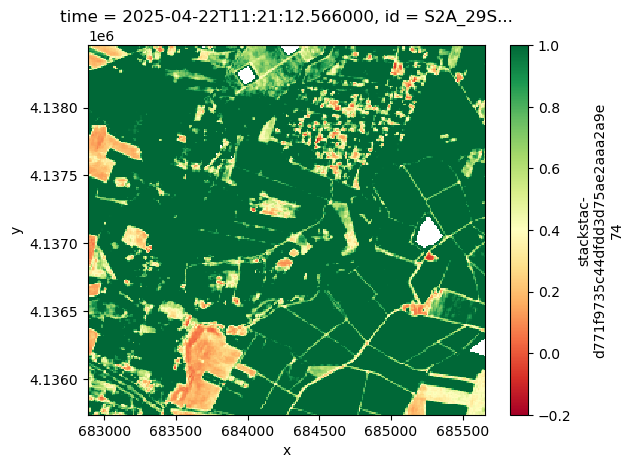

In [131]:
#Selecting time 0 to plot the NDVI
ndvi.isel(time=0).plot.imshow(cmap='RdYlGn', vmin=-0.2, vmax=1)


In [23]:
cube.band

<xarray.DataArray 'band' (band: 5)> Size: 100B
array(['red', 'green', 'blue', 'nir', 'scl'], dtype='<U5')
Coordinates: (12/50)
  * band                                     (band) <U5 100B 'red' ... 'scl'
    view:sun_azimuth                         float64 8B 145.1
    s2:degraded_msi_data_percentage          float64 8B 0.0116
    s2:datastrip_id                          <U64 256B 'S2A_OPER_MSI_L2A_DS_2...
    updated                                  <U24 96B '2025-04-22T19:32:50.586Z'
    earthsearch:s3_path                      <U79 316B 's3://sentinel-cogs/se...
    ...                                       ...
    title                                    (band) <U30 600B 'Red - 10m' ......
    gsd                                      (band) int64 40B 10 10 10 10 20
    common_name                              (band) object 40B 'red' ... None
    center_wavelength                        (band) object 40B 0.665 ... None
    full_width_half_max                      (band) object 40B 0.038 ... None
    epsg                                     int64 8B 32629

In [134]:
# Adding NDVI to the CUBE
ndvi_expanded = ndvi.expand_dims(dim = 'band')
ndvi_expanded = ndvi_expanded.assign_coords(band=['ndvi'])

# Create median cube with original bands
cube_vis = cube.sel(band=['red', 'green', 'blue', 'nir']).median('time', keep_attrs=True)

# Concatenate NDVI as a new band
combined_cube = xr.concat([cube_vis, ndvi_expanded], dim='band')

# Verify
print(combined_cube.band.values)
combined_cube.sel(band='ndvi').plot.imshow(cmap='RdYlGn')


ValueError: coordinate 'title' not present in all datasets.

In [67]:
ndvi_dims = ('time', 'y', 'x') 
cube['NDVI'] = xr.DataArray(ndvi, dims=ndvi_dims)

In [76]:
cube['NDVI'].to_dataframe()

id  \
time                    y            x                                         
2025-04-22 11:21:12.566 4.138455e+06 682890.462898  S2A_29SPB_20250422_0_L2A   
                                     682900.834867  S2A_29SPB_20250422_0_L2A   
                                     682911.206837  S2A_29SPB_20250422_0_L2A   
                                     682921.578806  S2A_29SPB_20250422_0_L2A   
                                     682931.950775  S2A_29SPB_20250422_0_L2A   
...                                                                      ...   
                        4.135743e+06 685607.918871  S2A_29SPB_20250422_0_L2A   
                                     685618.290840  S2A_29SPB_20250422_0_L2A   
                                     685628.662810  S2A_29SPB_20250422_0_L2A   
                                     685639.034779  S2A_29SPB_20250422_0_L2A   
                                     685649.406749  S2A_29SPB_20250422_0_L2A   

                                                    view:azimuth  \
time                    y            x                             
2025-04-22 11:21:12.566 4.138455e+06 682890.462898    103.795764   
                                     682900.834867    103.795764   
                                     682911.206837    103.795764   
                                     682921.578806    103.795764   
                                     682931.950775    103.795764   
...                                                          ...   
                        4.135743e+06 685607.918871    103.795764   
                                     685618.290840    103.795764   
                                     685628.662810    103.795764   
                                     685639.034779    103.795764   
                                     685649.406749    103.795764   

                                                                        s2:datatake_id  \
time                    y            x                                                   
2025-04-22 11:21:12.566 4.138455e+06 682890.462898  GS2A_20250422T110651_051357_N05.11   
                                     682900.834867  GS2A_20250422T110651_051357_N05.11   
                                     682911.206837  GS2A_20250422T110651_051357_N05.11   
                                     682921.578806  GS2A_20250422T110651_051357_N05.11   
                                     682931.950775  GS2A_20250422T110651_051357_N05.11   
...                                                                                ...   
                        4.135743e+06 685607.918871  GS2A_20250422T110651_051357_N05.11   
                                     685618.290840  GS2A_20250422T110651_051357_N05.11   
                                     685628.662810  GS2A_20250422T110651_051357_N05.11   
                                     685639.034779  GS2A_20250422T110651_051357_N05.11   
                                     685649.406749  GS2A_20250422T110651_051357_N05.11   

                                                    s2:nodata_pixel_percentage  \
time                    y            x                                           
2025-04-22 11:21:12.566 4.138455e+06 682890.462898                    4.083012   
                                     682900.834867                    4.083012   
                                     682911.206837                    4.083012   
                                     682921.578806                    4.083012   
                                     682931.950775                    4.083012   
...                                                                        ...   
                        4.135743e+06 685607.918871                    4.083012   
                                     685618.290840                    4.083012   
                                     685628.662810                    4.083012   
                                     685639.034779                    4.083